In [3]:
import pandas as pd
import numpy as np
import time
import pickle
import re 
import matplotlib.pyplot as plt
import nvstrings
import warnings
import cudf as gd
import torch
import torch.nn

from numba import cuda
from sklearn.metrics import roc_auc_score
from datetime import date
from fastai.callbacks import *
from fastai import *
from fastai.tabular import *
from fastai.text import *
from fastai.metrics import accuracy
from multiprocessing import Process
from os import listdir
from os.path import isfile, join
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
import os
GPU_id = 3
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [5]:
torch.cuda.current_device()

0


<h2> Functions </h2>

In [6]:
#########################
#                       #
# Metrics and callbacks #
#                       #
#########################

def write_pkl(obj, file_path=None):
    if not file_path:
        date_time = date.fromtimestamp(time.time()).strftime("%m_%d_%Y_%H-%M-%S")
        file_path=f'{date_time}.csv'
    if os.path.exists(file_path):
        os.remove(file_path)
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj, protocol=4)
    with open(file_path, 'wb') as f_out:
        for idx in range(0, len(bytes_out), max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])


def get_mean_reciprocal_rank(sub):
    # sub is a pandas dataframe
    # sub should have the following columns:
    # 'row_id', 'prob', 'reference', 'item_id'
    # sorted by prob in descending order for each group
    sub = gd.from_pandas(sub)
    
    def get_order_in_group(prob,row_id,order):
        for i in range(cuda.threadIdx.x, len(prob), cuda.blockDim.x):
            order[i] = i

    dg = sub.groupby('row_id',method="cudf").apply_grouped(get_order_in_group,incols=['prob','row_id'],
                                  outcols={'order': np.int32},
                                  tpb=32)

    dg = dg.to_pandas()
    dg['order'] = 1.0/(1+dg['order'])
    dg = dg[dg['reference']==dg['item_id']]
    print(dg.isnull().values.any())
    return dg['order'].mean()

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

# Callback to calculate AUC at the end of each epoch
class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []

    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)

    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

        
def get_idx(x): 
    return 0 if pd.isnull(x) else id_to_index.get(str(x), 0)

<h1> <center> Data Processing </center> </h1>

In [ ]:
with open('cache/id_to_index.pkl', 'rb') as handle:
    id_to_index = pickle.load(handle)

In [ ]:
%%time
#load tabular data 
data_pair = pd.read_pickle('cache/data_pair_all.pkl')
data_pair = data_pair.drop(columns = [c for c in data_pair.columns if c.startswith('delta') or c.startswith('is')])

In [ ]:
%%time
data_context = pd.read_csv('cache/context_info.csv')
data_context['past_clickout_item'] = data_context['past_clickout_item'].apply(get_idx)
data_context['future_clickout_item'] = data_context['future_clickout_item'].apply(get_idx)

In [ ]:
data_context.head()

In [ ]:
%%time
data_pair = data_pair.merge(data_context, on='row_id', how='left')

In [ ]:
data_pair['past_clickout_price_diff'] = data_pair['price'] - data_pair['past_clickout_price']
data_pair['future_clickout_price_diff'] = data_pair['price'] - data_pair['future_clickout_price']

In [ ]:
# get the train and test dataset 
train = data_pair[data_pair.clickout_missing==0]
test = data_pair[data_pair.clickout_missing>0]
print(train.shape,test.shape)

<h2> Tabular model </h2> 

<h3> Input Data </h3> 

In [ ]:
%%time 
cat_names = ['user_id','item_id','platform','city','device','current_filters']
cat_names +=['past_clickout_available', 
             'past_clickout_is_same', 
             'past_clickout_impression_valid', 
             'future_clickout_available',
             'future_clickout_is_same', 
             'future_clickout_impression_valid']

cont_names = ['price','candidate_order','item_count'] + [i for i in train.columns if i.startswith('count') or 'rank' in i or i.startswith('delta_')]
cont_names += [ 'past_clickout_step_diff', 
                'past_clickout_timestamp_diff',
                'past_clickout_price', 
                'past_clickout_price_mean',  
                'past_clickout_price_std',
                'past_clickout_price_diff',
                'cur_item_count_past',
                'future_clickout_step_diff', 
                'future_clickout_timestamp_diff',
                'future_clickout_price',   
                'future_clickout_price_mean', 
                'future_clickout_price_std',
                'future_clickout_price_diff',
                'cur_item_count_future']

procs = [FillMissing,Categorify, Normalize]
train['is_va'] = train.row_id%5 == 0

test_list = TabularList.from_df(test, path='./', cat_names=cat_names, cont_names=cont_names)

data_tab = (TabularList.from_df(train, path='./', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_from_df('is_va')
                           .label_from_df(cols='target')
                           .add_test(test_list)
                           .databunch(num_workers=10,bs=1024))

In [ ]:
%%time 
write_pkl(data_tab)

In [ ]:
%%time 
data_pair.to_pickle('cache/data_pair_context.pkl')
del data_pair

In [ ]:
%%time
learn_tab = tabular_learner(data_tab, layers=[64], metrics=None, callback_fns=AUROC,#wd=0.2,
        emb_szs = {'user_id': 16,'item_id':32,'platform':4,'city':8,'device':1,
                   'current_filters':8})

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(3e-3), callbacks=[SaveModelCallback(learn,
        every='improvement', monitor='AUROC',name='tab_nn')])

In [ ]:
learn_tab.model

In [ ]:
# we drop the output classification layer,
learn_tab.model.layers = learn_tab.model.layers[:-3]

In [ ]:
learn_tab.model

<h2> <left> Binary features from metadata</left> </h2>

In [ ]:
%%time
bin_feature = pd.read_csv('bin_itemmeta.csv')
bin_feature.rename(columns={'index': 'item_id'}, inplace=True)
bin_feature.drop(columns=['Unnamed: 0', 'Unnamed: 2'], inplace=True)

In [ ]:
%%time
item_embd_idx = 'item_embd_idx'

bin_feature[item_embd_idx] = bin_feature['item_id'].apply(get_idx)
bin_feature_cols = [c for c in bin_feature.columns if c != item_embd_idx and c != 'item_id']
bin_feature = bin_feature[bin_feature[item_embd_idx] != 0]
max_idx = max(id_to_index.values())
bin_feature_matrix = np.random.rand(max_idx+1, bin_feature.shape[1]-2)
bin_feature_matrix[bin_feature['item_embd_idx'], :] = bin_feature[bin_feature_cols].values

In [ ]:
# test equivalency
rand_row = random.choice(range(bin_feature.shape[0]))
embed_orig = bin_feature.iloc[rand_row][bin_feature_cols].values
idx = bin_feature.iloc[rand_row][item_embd_idx]
embed_matrix = bin_feature_matrix[idx, :]
print("embedding matrix matched: {}".format(np.array_equal(embed_matrix, embed_orig))

In [ ]:
np.save('cache/bin_feature_matrix', bin_feature_matrix)
bin_feature_matrix = torch.from_numpy(bin_feature_matrix).float().cuda()

<h2> <left> Concate dataset </left> </h2>

In [12]:
class DatasetPast(Dataset):
    def __init__(self, data): 
        self.data = data
    def __len__(self): 
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [13]:
%%time
context_cols = ['past_clickout_item', 'future_clickout_item']
train_past_future_click = train[train.is_va==0][context_cols].values
valid_past_future_click = train[train.is_va==1][context_cols].values
test_past_future_click = test[context_cols].values

CPU times: user 9.76 s, sys: 10.7 s, total: 20.5 s
Wall time: 20.5 s


In [14]:
class ConcatDataset(Dataset):
    def __init__(self, x_tab, x_pf_click, y):
        self.x_tab = x_tab
        self.x_pf_click = x_pf_click
        self.y = [0] * len(x_pf_click) if not y else y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return (self.x_tab[i],  self.x_pf_click[i]), self.y[i]

train_ds = ConcatDataset(data_tab.train_ds.x, train_past_future_click, data_tab.train_ds.y)
valid_ds = ConcatDataset(data_tab.valid_ds.x, valid_past_future_click, data_tab.valid_ds.y)
test_ds =  ConcatDataset(data_tab.test_ds.x, test_past_future_click, None)

In [15]:
def my_collate(batch): 
    x, y = list(zip(*batch))
    x_tab, x_pf_click = list(zip(*x))
    x_cats, x_conts = zip(*[(t.cats, t.conts) for t in x_tab])
    x_cats = torch.tensor(x_cats, dtype=torch.long)
    x_conts = torch.tensor(x_conts, dtype=torch.float)
    x_pf_click = torch.tensor(x_pf_click, dtype=torch.long)
    y = torch.tensor([int(t) for t in y])
    return ((x_cats, x_conts), x_pf_click), y

In [16]:
bs = 1024
train_dl = DataLoader(train_ds, bs, collate_fn=my_collate, shuffle=True)
valid_dl = DataLoader(valid_ds, bs, collate_fn=my_collate, shuffle=True)
test_dl = DataLoader(test_ds, bs, collate_fn=my_collate, shuffle=True)

In [17]:
batch = train_dl.__iter__().__next__()

In [18]:
batch[0][1]

tensor([[204893,      0],
        [520531,      0],
        [     0,      0],
        ...,
        [158680,  91515],
        [457455,      0],
        [ 16120,  64160]])

In [19]:
data = DataBunch(train_dl=train_dl, valid_dl=valid_dl, test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path="./")

In [20]:
import torch

class WrapModel(nn.Module):
    def __init__(self, mod_tab, layers, bin_feature_matrix, id_emb_matrix_idx, p=0.2):

        super(WrapModel, self).__init__()
        self.mod_tab = mod_tab
        # this is the index of the id embedding in embeds.
        self.bin_feature_matrix = bin_feature_matrix
        self.id_embed = mod_tab.embeds[id_emb_matrix_idx]
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        lst_layers = []
        activs = [nn.ReLU(inplace=True), ] * (len(layers) - 2) + [None]
        for i in range(len(layers) - 1):
            lst_layers += bn_drop_lin(layers[i], layers[i + 1], p, actn=activs[i])
        self.layers = nn.Sequential(*lst_layers)

    def get_cosine_similarity(self, x1, x2):
        out = self.cos(x1, x2).unsqueeze(1)
        out = out.detach()
        return out

    def forward(self, *x):
        # x[0] is tab, x[0][0] is cat, x[0][0][:, 1] is item_id
        x_cur_id = x[0][0][:, 1]
        x_tab = self.mod_tab(*x[0])
        x_cur_bin = self.bin_feature_matrix[x_cur_id, :]
        x_cur_emb = self.id_embed(x_cur_id)


        x_past_id = x[1][:, 0]
        x_past_bin = self.bin_feature_matrix[x_past_id, :]
        x_past_emb = self.id_embed(x_past_id)

        x_future_id = x[1][:, 1]
        x_future_bin = self.bin_feature_matrix[x_future_id, :]
        x_future_emb = self.id_embed(x_future_id)

        x_past_cur_bin_sim = self.get_cosine_similarity(x_cur_bin, x_past_bin)
        x_past_cur_emb_sim = self.get_cosine_similarity(x_cur_emb, x_past_emb)

        x_future_cur_bin_sim = self.get_cosine_similarity(x_cur_bin, x_future_bin)
        x_future_cur_emb_sim = self.get_cosine_similarity(x_cur_emb, x_future_emb)

        x_past_future_bin_sim = self.get_cosine_similarity(x_past_bin, x_future_bin)
        x_past_future_emb_sim = self.get_cosine_similarity(x_past_emb, x_future_emb)

        x = torch.cat([x_tab, x_past_cur_bin_sim, x_past_cur_emb_sim, x_future_cur_bin_sim,
                       x_future_cur_emb_sim, x_past_future_bin_sim, x_past_future_emb_sim], dim=1)

        return self.layers(x)

In [ ]:
lin_layers = [64+6, 32, 16, 2]
ps = [0.2]
model = WrapModel(learn_tab.model, lin_layers, bin_feature_matrix, 1)
learn = Learner(data, model, metrics=None, callback_fns=AUROC)

In [ ]:
learn.save("trained_fastai_context_and_binary")

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, slice(1e-2))

In [ ]:
learn.recorder.plot_losses()

### For convenience, load everything saved before

In [7]:
%%time
data_tab = pickle.load(open('06_28_2019_00-00-00.csv', 'rb'))

CPU times: user 10 s, sys: 35.1 s, total: 45.2 s
Wall time: 45.1 s


In [8]:
%%time
learn_tab = tabular_learner(data_tab, layers=[64], metrics=None, callback_fns=AUROC,#wd=0.2,
        emb_szs = {'user_id': 16,'item_id':32,'platform':4,'city':8,'device':1,
                   'current_filters':8})
learn_tab.model.layers = learn_tab.model.layers[:-3]

CPU times: user 8.04 s, sys: 3 s, total: 11 s
Wall time: 12.7 s


In [9]:
%%time
data_pair = pd.read_pickle('cache/data_pair_context.pkl')
train = data_pair[data_pair.clickout_missing==0]
test = data_pair[data_pair.clickout_missing>0]
train['is_va'] = train.row_id%5 == 0

CPU times: user 22.3 s, sys: 29.9 s, total: 52.2 s
Wall time: 2min 26s


In [11]:
%%time
bin_feature_matrix =np.load('cache/bin_feature_matrix.npy')
bin_feature_matrix = torch.from_numpy(bin_feature_matrix).float().cuda()

CPU times: user 480 ms, sys: 1.89 s, total: 2.37 s
Wall time: 7.7 s


#### Reload model and databunch

In [21]:
%%time
lin_layers = [64+6, 32, 16, 2]
ps = [0.2]
model = WrapModel(learn_tab.model, lin_layers, bin_feature_matrix, 1)
learn = Learner(data, model, metrics=None, callback_fns=AUROC)
learn = learn.load("trained_fastai_context_and_binary")

CPU times: user 820 ms, sys: 2.31 s, total: 3.13 s
Wall time: 9.64 s


### Performance

In [22]:
%%time
yp, y_valid = learn.get_preds()

CPU times: user 8min 52s, sys: 1min 34s, total: 10min 27s
Wall time: 9min 54s


In [23]:
%%time
cv = train.loc[train['row_id']%5 == 0,['row_id','reference','item_id', 'target']].copy()
cv['prob'] = yp.numpy()[:,1]
cv = cv.sort_values(by=['row_id','prob'],ascending=False)
# del train

CPU times: user 10.7 s, sys: 5.7 s, total: 16.4 s
Wall time: 16.4 s


CPU times: user 3.92 s, sys: 524 ms, total: 4.45 s
Wall time: 4.45 s


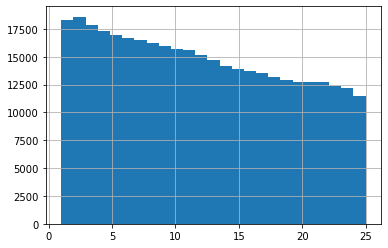

In [24]:
%%time
cv['rank']=cv.groupby('row_id')['prob'].rank(ascending=False) 
target_rank = cv[cv['target']==1]['rank']
target_rank.hist(bins=25)

In [25]:
%%time
auc = roc_auc_score(y_valid.numpy().ravel(),yp.numpy()[:,1])
mean_reciprocal_rank = (1/target_rank).mean() # get_mean_reciprocal_rank(cv)
print('mean_reciprocal_rank %.4f, AUC %.4f'%(mean_reciprocal_rank,auc))

mean_reciprocal_rank 0.1722, AUC 0.9266
CPU times: user 2.9 s, sys: 1.36 s, total: 4.26 s
Wall time: 4.25 s


In [27]:
%%time
cv['prob'] = yp.numpy()[:,1]
cv['prob0'] = yp.numpy()[:,0]
tp = sum(cv[cv['target']==1]['prob']>cv[cv['target']==1]['prob0'])
fp = sum(cv[cv['target']==1]['prob']<=cv[cv['target']==1]['prob0'])
tn = sum(cv[cv['target']==0]['prob']<cv[cv['target']==0]['prob0'])
fn = sum(cv[cv['target']==0]['prob']>=cv[cv['target']==0]['prob0'])
print(tp,fp,tn,fn)

6962 364334 8026587 153460
CPU times: user 1.7 s, sys: 1 s, total: 2.7 s
Wall time: 2.7 s


In [ ]:
%%time
yps,_ = learn.get_preds(DatasetType.Test)

In [ ]:
%%time
test['target'] = yps.numpy()[:,1]
test = test['row_id,user_id,session_id,timestamp,step,item_id,target'.split(',')]
test.head()

In [ ]:
%%time
test = test.sort_values(by=['row_id','target'],ascending=False) # larger probs first

In [ ]:
%%time
sub = test[['row_id','item_id']].copy()
sub = sub.groupby('row_id')['item_id'].apply(lambda x: ' '.join([str(i) for i in x]))
sub = sub.to_frame()
sub.columns = ['new_item_recommendations']
sub = sub.reset_index()

test = test.drop_duplicates(subset=['row_id'])
sub = test.merge(sub,on='row_id',how='left')
sub = sub[['session_id','new_item_recommendations']]

In [ ]:
%%time
sample_sub = pd.read_csv('/datasets/trivago/data/submission_popular.csv')
# sample_sub = pd.read_csv('../input/submission_popular.csv')
assert sample_sub.shape[0] == sample_sub.session_id.unique().shape[0]
sub = sample_sub.merge(sub,on='session_id',how='left')

from datetime import datetime
clock = "{}".format(datetime.now()).replace(' ','-').replace(':','-').split('.')[0]

mask = sub.new_item_recommendations.isnull() == 0
sub.loc[mask,'item_recommendations'] = sub.loc[mask,'new_item_recommendations']
sub = sub.drop('new_item_recommendations',axis=1)
out = 'fastai_%s_mrr_%.4f_auc_%.4f.csv'%(clock,mean_reciprocal_rank,auc)
sub.to_csv(out,index=False)

sub.head()